# Proyecto Final
# Prediccion de producto semanales
Deep learning
* Javier Prado - 21486
* Bryan España - 21550

In [27]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [28]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [29]:
df = pd.read_csv('data/demand_weekly_chocolates_2018-2024.csv')
df['week_start'] = pd.to_datetime(df['week_start'])
df.head()

,week_start,demand,promo_flag,promo_lift,promo_carryover,holiday_flag,holiday_lead_flag,holiday_decay_flag,year,month,week_of_year
0,2018-01-01,34,0,0.0,0.0,0,0,0,2018,1,1
1,2018-01-08,45,0,0.0,0.0,0,0,0,2018,1,2
2,2018-01-15,35,0,0.0,0.0,0,0,0,2018,1,3
3,2018-01-22,29,0,0.0,0.0,0,0,0,2018,1,4
4,2018-01-29,49,0,0.0,0.0,0,0,0,2018,1,5


In [30]:
df.tail()

,week_start,demand,promo_flag,promo_lift,promo_carryover,holiday_flag,holiday_lead_flag,holiday_decay_flag,year,month,week_of_year
361,2024-12-02,34,0,0.0,0.0,0,0,1,2024,12,49
362,2024-12-09,41,0,0.0,0.0,0,0,0,2024,12,50
363,2024-12-16,89,0,0.0,0.0,0,1,0,2024,12,51
364,2024-12-23,62,0,0.0,0.0,1,1,0,2024,12,52
365,2024-12-30,83,0,0.0,0.0,1,0,1,2024,12,1


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   week_start          366 non-null    datetime64[ns]
 1   demand              366 non-null    int64         
 2   promo_flag          366 non-null    int64         
 3   promo_lift          366 non-null    float64       
 4   promo_carryover     366 non-null    float64       
 5   holiday_flag        366 non-null    int64         
 6   holiday_lead_flag   366 non-null    int64         
 7   holiday_decay_flag  366 non-null    int64         
 8   year                366 non-null    int64         
 9   month               366 non-null    int64         
 10  week_of_year        366 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(8)
memory usage: 31.6 KB


In [32]:
df.columns

Index(['week_start', 'demand', 'promo_flag', 'promo_lift', 'promo_carryover',
       'holiday_flag', 'holiday_lead_flag', 'holiday_decay_flag', 'year',
       'month', 'week_of_year'],
      dtype='object')

El dataset nos brinda datos de un producto desde las fechas 1 de enero del 2018 hasta la última semana del mes de diciembre del año 2014.
Las columnas del dataset son las siguientes:
- week_start: Marca el índice temporal semanal (lunes–domingo).
- demand: unidades vendidas esa semana
- promo_flag: indicador 0/1 de si hubo promoción esa semana.
- promo_lift: proporción (p. ej., 0.25 = +25%) que el simulador aplicó por la promo en esa semana.
- promo_carryover: proporción de “arrastre” de la promo hacia la semana siguiente
- holiday_flag: indicador 0/1 de que la semana incluye un feriado/evento principa
- holiday_lead_flag: indicador 0/1 de semana previa al feriado
- holiday_Decay_flag: indicador 0/1 de semana posterior al feriado
- year: año del week_start
- month: mes del week_start
- week_of_year: semana del año (1-53)
Sumando 366 entradas en total: 1 entrada --> 1 semana 

In [33]:
def print_statistical_summary(df):
    """Imprime un resumen estadístico detallado de la demanda"""

    
    print("="*60)
    print("RESUMEN ESTADISTICO DE LA VARIABLE TARGET 'DEMAND'")
    print("="*60)
    
    print(f"\nESTADISTICAS DESCRIPTIVAS:")
    print(f"   • Número de observaciones: {len(df)}")
    print(f"   • Media: {df['demand'].mean():.2f}")
    print(f"   • Mediana: {df['demand'].median():.2f}")
    print(f"   • Desviación estándar: {df['demand'].std():.2f}")
    print(f"   • Varianza: {df['demand'].var():.2f}")
    print(f"   • Minimo: {df['demand'].min()}")
    print(f"   • Maximo: {df['demand'].max()}")
    print(f"   • Rango: {df['demand'].max() - df['demand'].min()}")
    
    print(f"\nPERCENTILES:")
    percentiles = [10, 25, 50, 75, 90, 95, 99]
    for p in percentiles:
        value = np.percentile(df['demand'], p)
        print(f"   • P{p}: {value:.2f}")
    
    print(f"\nANALISIS DE FORMA:")
    skewness = df['demand'].skew()
    kurtosis = df['demand'].kurtosis()
    print(f"   • Asimetría (Skewness): {skewness:.3f}")
    if skewness > 0:
        print("     → Distribucion sesgada hacia la derecha")
    elif skewness < 0:
        print("     → Distribucion sesgada hacia la izquierda")
    else:
        print("     → Distribucion simetrica")
    
    print(f"   • Curtosis: {kurtosis:.3f}")
    if kurtosis > 0:
        print("     → Distribucion leptocúrtica (más puntiaguda)")
    elif kurtosis < 0:
        print("     → Distribucio platocúrtica (más plana)")
    else:
        print("     → Distribucion mesocúrtica (normal)")
    
    print(f"\n ANÁLISIS DE OUTLIERS:")
    Q1 = df['demand'].quantile(0.25)
    Q3 = df['demand'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df['demand'] < lower_bound) | (df['demand'] > upper_bound)]
    
    print(f"   • Límite inferior: {lower_bound:.2f}")
    print(f"   • Límite superior: {upper_bound:.2f}")
    print(f"   • Número de outliers: {len(outliers)}")
    print(f"   • Porcentaje de outliers: {len(outliers)/len(df)*100:.2f}%")
    
    if len(outliers) > 0:
        print(f"   • Valores atípicos: {sorted(outliers['demand'].tolist())}")
    
    
    # Análisis por factores
    print(f"\nANÁLISIS POR PROMOCIONES:")
    promo_stats = df.groupby('promo_flag')['demand'].agg(['mean', 'std', 'count'])
    print(f"   • Sin promoción - Media: {promo_stats.loc[0, 'mean']:.2f}, Std: {promo_stats.loc[0, 'std']:.2f}, N: {promo_stats.loc[0, 'count']}")
    if 1 in promo_stats.index:
        print(f"   • Con promoción - Media: {promo_stats.loc[1, 'mean']:.2f}, Std: {promo_stats.loc[1, 'std']:.2f}, N: {promo_stats.loc[1, 'count']}")
    
    print(f"\nANÁLISIS POR DÍAS FESTIVOS:")
    holiday_stats = df.groupby('holiday_flag')['demand'].agg(['mean', 'std', 'count'])
    print(f"   • Días normales - Media: {holiday_stats.loc[0, 'mean']:.2f}, Std: {holiday_stats.loc[0, 'std']:.2f}, N: {holiday_stats.loc[0, 'count']}")
    if 1 in holiday_stats.index:
        print(f"   • Días festivos - Media: {holiday_stats.loc[1, 'mean']:.2f}, Std: {holiday_stats.loc[1, 'std']:.2f}, N: {holiday_stats.loc[1, 'count']}")

print_statistical_summary(df)

RESUMEN ESTADISTICO DE LA VARIABLE TARGET 'DEMAND'

ESTADISTICAS DESCRIPTIVAS:
   • Número de observaciones: 366
   • Media: 55.86
   • Mediana: 52.50
   • Desviación estándar: 21.37
   • Varianza: 456.79
   • Minimo: 17
   • Maximo: 148
   • Rango: 131

PERCENTILES:
   • P10: 33.00
   • P25: 41.00
   • P50: 52.50
   • P75: 67.00
   • P90: 84.00
   • P95: 94.75
   • P99: 118.85

ANALISIS DE FORMA:
   • Asimetría (Skewness): 0.994
     → Distribucion sesgada hacia la derecha
   • Curtosis: 1.548
     → Distribucion leptocúrtica (más puntiaguda)

 ANÁLISIS DE OUTLIERS:
   • Límite inferior: 2.00
   • Límite superior: 106.00
   • Número de outliers: 10
   • Porcentaje de outliers: 2.73%
   • Valores atípicos: [107, 108, 111, 112, 112, 115, 126, 129, 141, 148]

ANÁLISIS POR PROMOCIONES:
   • Sin promoción - Media: 53.30, Std: 19.56, N: 303
   • Con promoción - Media: 68.19, Std: 25.28, N: 63

ANÁLISIS POR DÍAS FESTIVOS:
   • Días normales - Media: 52.67, Std: 18.64, N: 332
   • Días festiv

# Análisis Exploratorio de Datos (EDA) - Variable Target "demand"

Vamos a realizar un análisis completo de la variable objetivo para entender:
- Distribución y características estadísticas
- Patrones temporales y estacionalidad
- Relación con variables promocionales y festivos
- Identificación de outliers y tendencias

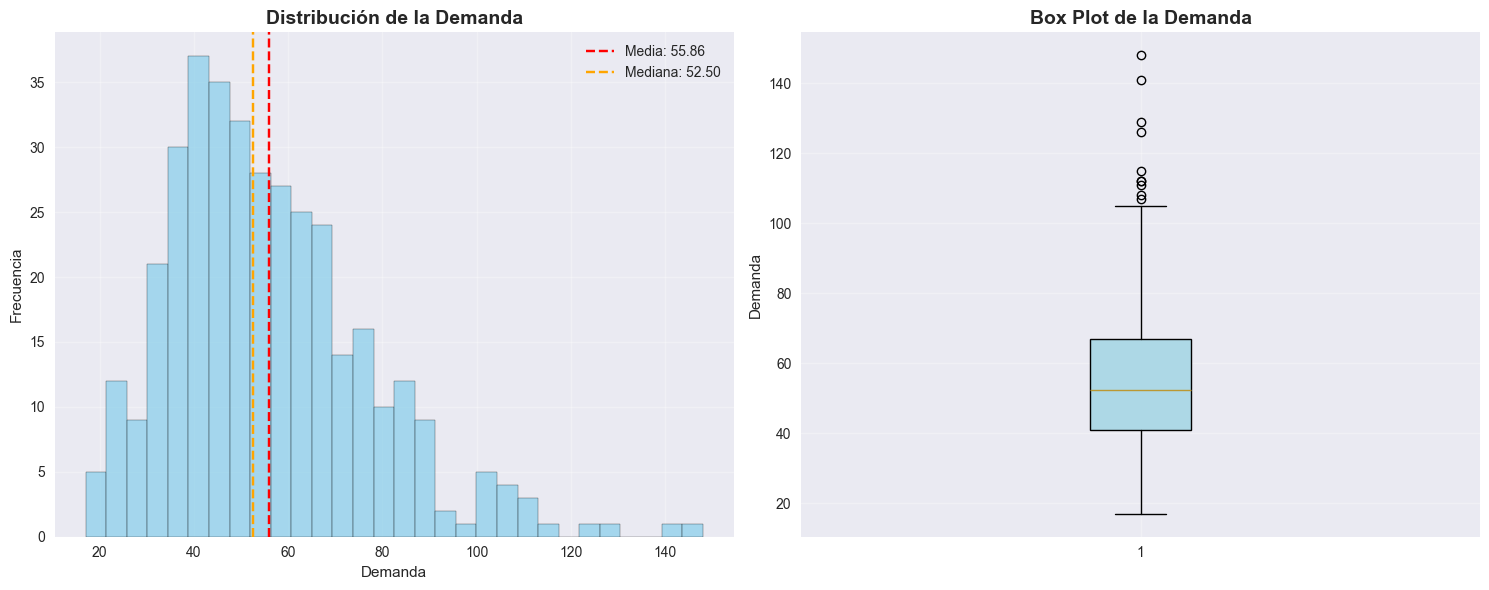

In [34]:
# 1. ANÁLISIS DE DISTRIBUCIÓN
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histograma
axes[0].hist(df['demand'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
mean_demand = df['demand'].mean()
median_demand = df['demand'].median()
axes[0].axvline(mean_demand, color='red', linestyle='--', label=f'Media: {mean_demand:.2f}')
axes[0].axvline(median_demand, color='orange', linestyle='--', label=f'Mediana: {median_demand:.2f}')
axes[0].set_title('Distribución de la Demanda', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Demanda')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
box_plot = axes[1].boxplot(df['demand'], patch_artist=True)
box_plot['boxes'][0].set_facecolor('lightblue')
axes[1].set_title('Box Plot de la Demanda', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Demanda')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

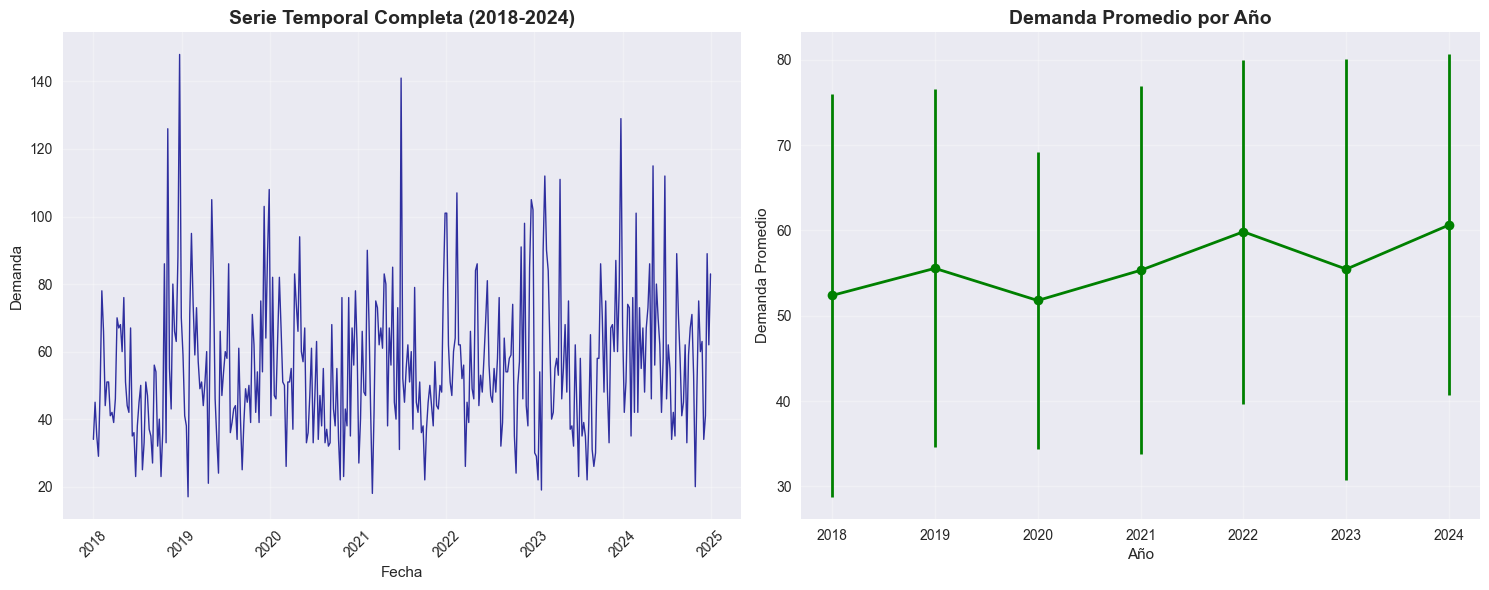

In [35]:
# 2. ANÁLISIS TEMPORAL COMPLETO
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Serie temporal completa
axes[0].plot(df['week_start'], df['demand'], linewidth=1, alpha=0.8, color='darkblue')
axes[0].set_title('Serie Temporal Completa (2018-2024)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Demanda')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)


# Demanda por año
yearly_demand = df.groupby('year')['demand'].agg(['mean', 'std']).reset_index()
axes[1].errorbar(yearly_demand['year'], yearly_demand['mean'], 
                   yerr=yearly_demand['std'], marker='o', capsize=5, linewidth=2, color='green')
axes[1].set_title('Demanda Promedio por Año', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Demanda Promedio')
axes[1].grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

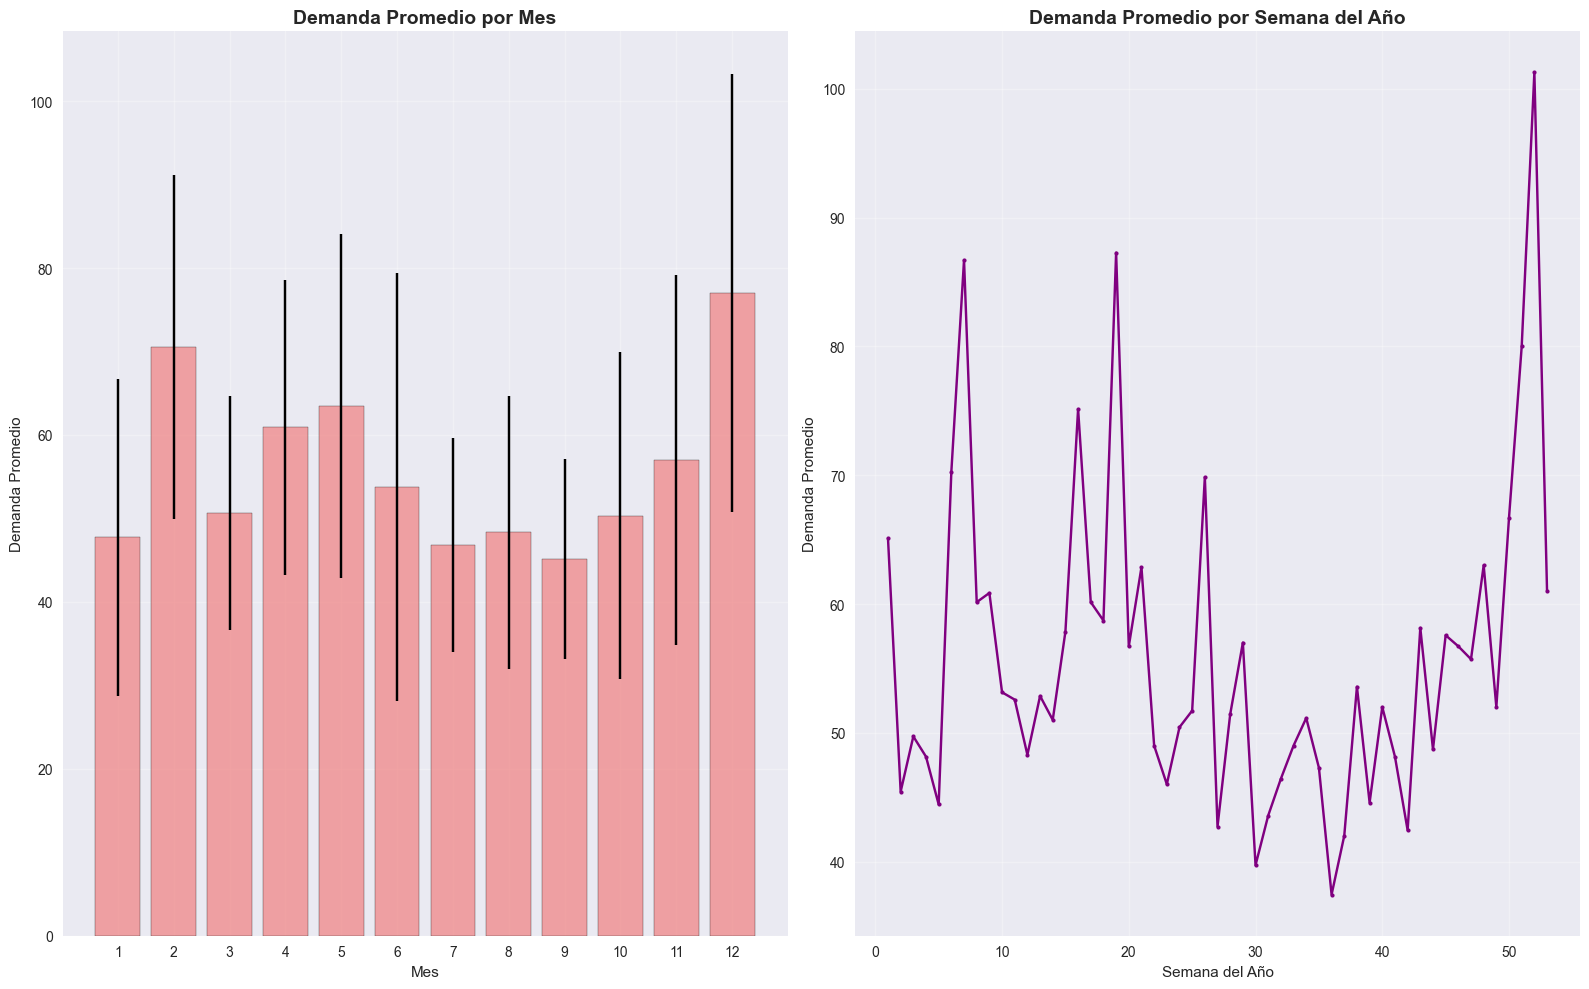

In [36]:
# 3. ANÁLISIS ESTACIONAL
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# Demanda por mes
monthly_demand = df.groupby('month')['demand'].agg(['mean', 'std']).reset_index()
axes[0].bar(monthly_demand['month'], monthly_demand['mean'], 
              color='lightcoral', alpha=0.7, edgecolor='black')
axes[0].errorbar(monthly_demand['month'], monthly_demand['mean'], 
                   yerr=monthly_demand['std'], fmt='none', color='black', capsize=3)
axes[0].set_title('Demanda Promedio por Mes', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Mes')
axes[0].set_ylabel('Demanda Promedio')
axes[0].set_xticks(range(1, 13))
axes[0].grid(True, alpha=0.3)

# Demanda por semana del año
weekly_demand = df.groupby('week_of_year')['demand'].mean()
axes[1].plot(weekly_demand.index, weekly_demand.values, marker='o', markersize=3, color='purple')
axes[1].set_title('Demanda Promedio por Semana del Año', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Semana del Año')
axes[1].set_ylabel('Demanda Promedio')
axes[1].grid(True, alpha=0.3)



plt.tight_layout()
plt.show()

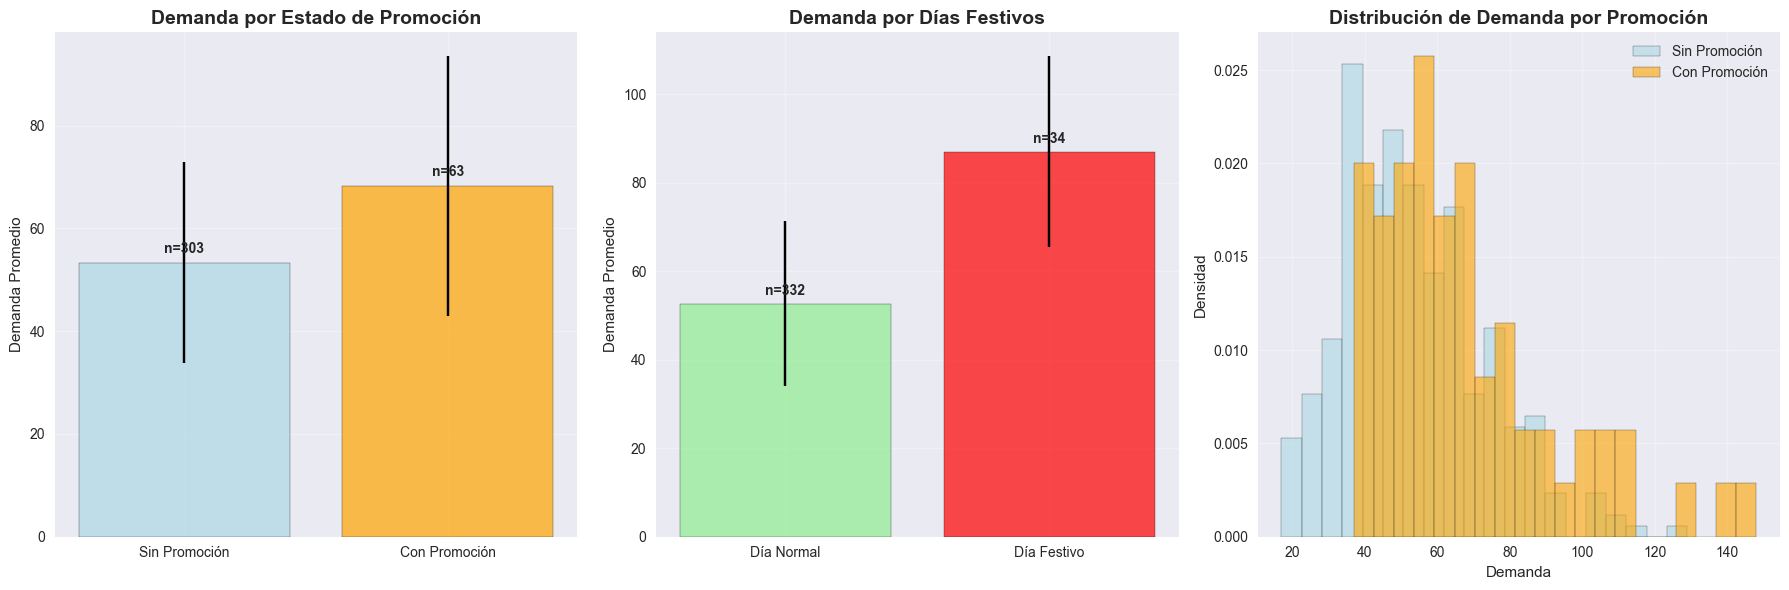

In [37]:
# 4. ANÁLISIS DE FACTORES EXTERNOS
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Efecto de promociones
promo_data = df.groupby('promo_flag')['demand'].agg(['mean', 'std', 'count']).reset_index()
promo_labels = ['Sin Promoción', 'Con Promoción']
axes[0].bar(range(len(promo_data)), promo_data['mean'], 
            yerr=promo_data['std'], capsize=5,
            color=['lightblue', 'orange'], alpha=0.7, edgecolor='black')
axes[0].set_title('Demanda por Estado de Promoción', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Demanda Promedio')
axes[0].set_xticks(range(len(promo_data)))
axes[0].set_xticklabels(promo_labels)
axes[0].grid(True, alpha=0.3)

# Agregar valores y conteos
for i, (mean_val, count) in enumerate(zip(promo_data['mean'], promo_data['count'])):
    axes[0].text(i, mean_val + 2, f'n={count}', ha='center', fontweight='bold')

# Efecto de días festivos
holiday_data = df.groupby('holiday_flag')['demand'].agg(['mean', 'std', 'count']).reset_index()
holiday_labels = ['Día Normal', 'Día Festivo']
axes[1].bar(range(len(holiday_data)), holiday_data['mean'], 
            yerr=holiday_data['std'], capsize=5,
            color=['lightgreen', 'red'], alpha=0.7, edgecolor='black')
axes[1].set_title('Demanda por Días Festivos', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Demanda Promedio')
axes[1].set_xticks(range(len(holiday_data)))
axes[1].set_xticklabels(holiday_labels)
axes[1].grid(True, alpha=0.3)

# Agregar valores y conteos
for i, (mean_val, count) in enumerate(zip(holiday_data['mean'], holiday_data['count'])):
    axes[1].text(i, mean_val + 2, f'n={count}', ha='center', fontweight='bold')

# Distribución de demanda por promoción (densidades)
for promo in df['promo_flag'].unique():
    subset = df[df['promo_flag'] == promo]['demand']
    label = 'Con Promoción' if promo == 1 else 'Sin Promoción'
    color = 'orange' if promo == 1 else 'lightblue'
    axes[2].hist(subset, alpha=0.6, label=label, bins=20, 
                 density=True, color=color, edgecolor='black')
axes[2].set_title('Distribución de Demanda por Promoción', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Demanda')
axes[2].set_ylabel('Densidad')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

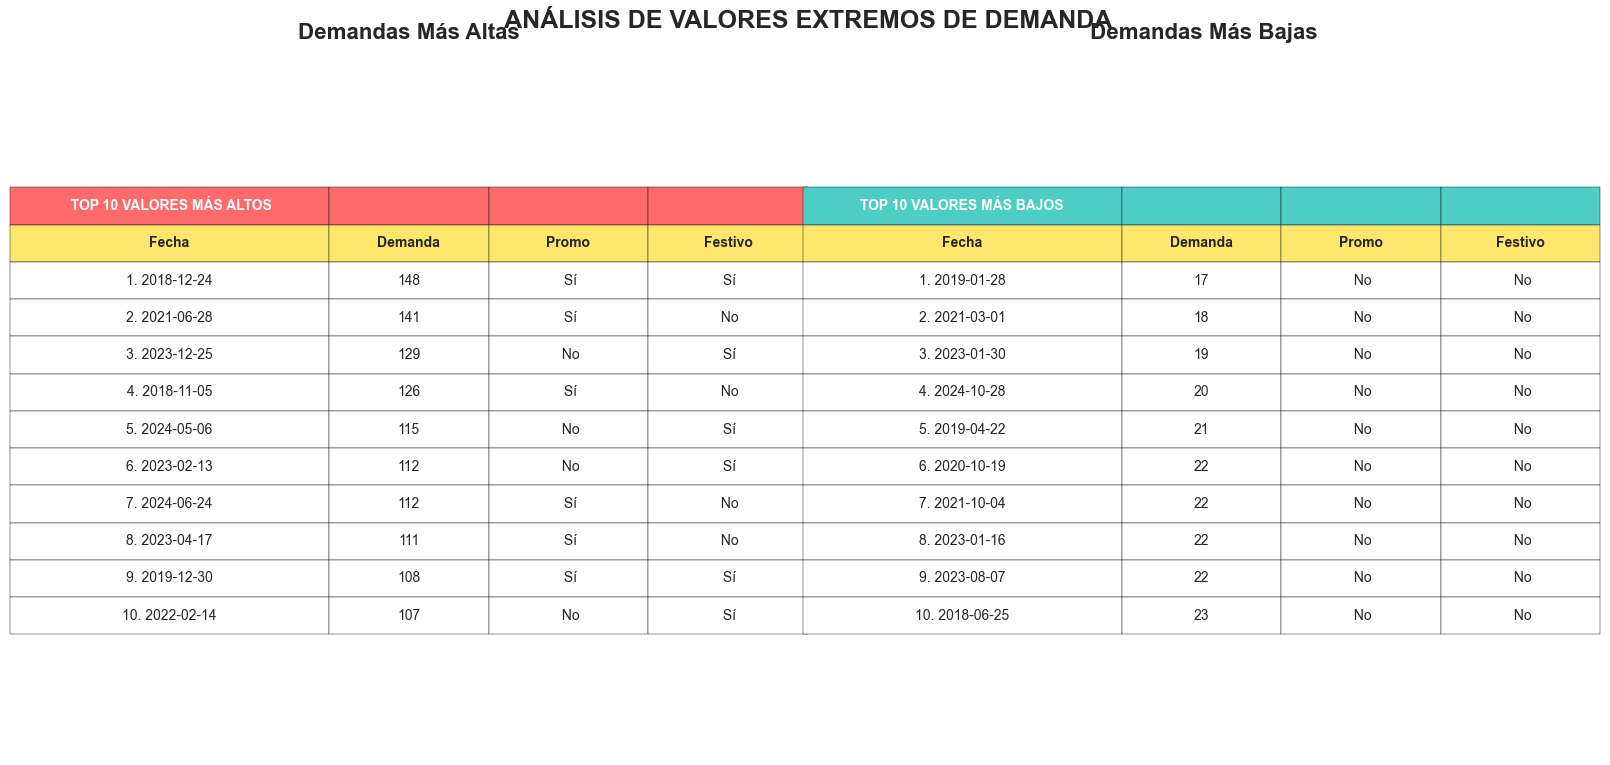

RESUMEN DE VALORES EXTREMOS

VALORES MÁS ALTOS:
   • Demanda máxima: 148 (2018-12-24)
   • Promedio top 10: 120.90
   • Con promoción: 6/10
   • En días festivos: 6/10

VALORES MÁS BAJOS:
   • Demanda mínima: 17 (2019-01-28)
   • Promedio bottom 10: 20.60
   • Con promoción: 0/10
   • En días festivos: 0/10

INSIGHTS CLAVE:
   • Diferencia máx-mín: 131 unidades
   • Factor de variación: 8.7x

DISTRIBUCIÓN POR AÑOS:
   VALORES ALTOS:
   • 2018: 2 casos
   • 2019: 1 casos
   • 2021: 1 casos
   • 2022: 1 casos
   • 2023: 3 casos
   • 2024: 2 casos
   VALORES BAJOS:
   • 2018: 1 casos
   • 2019: 2 casos
   • 2020: 1 casos
   • 2021: 2 casos
   • 2023: 3 casos
   • 2024: 1 casos


In [38]:
# 5. ANÁLISIS DE OUTLIERS Y ANOMALÍAS - TOP 10 VALORES EXTREMOS

# Obtener top 10 valores más altos y más bajos
top_demands = df.nlargest(10, 'demand')[['week_start', 'demand', 'promo_flag', 'holiday_flag']]
bottom_demands = df.nsmallest(10, 'demand')[['week_start', 'demand', 'promo_flag', 'holiday_flag']]

# Crear figura con dos subplots para las tablas
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# TABLA 1: TOP 10 VALORES MÁS ALTOS
axes[0].axis('tight')
axes[0].axis('off')
table_data_high = []
table_data_high.append([' TOP 10 VALORES MÁS ALTOS', '', '', ''])
table_data_high.append(['Fecha', 'Demanda', 'Promo', 'Festivo'])
for i, (_, row) in enumerate(top_demands.iterrows(), 1):
    table_data_high.append([
        f"{i}. {row['week_start'].strftime('%Y-%m-%d')}", 
        f"{row['demand']:.0f}",
        ' Sí' if row['promo_flag'] == 1 else ' No',
        ' Sí' if row['holiday_flag'] == 1 else ' No'
    ])

table_high = axes[0].table(cellText=table_data_high, 
                          cellLoc='center',
                          loc='center',
                          colWidths=[0.4, 0.2, 0.2, 0.2])
table_high.auto_set_font_size(False)
table_high.set_fontsize(10)
table_high.scale(1.2, 2)

# Colorear encabezados
for i in range(4):
    table_high[(0, i)].set_facecolor('#ff6b6b')
    table_high[(0, i)].set_text_props(weight='bold', color='white')
    table_high[(1, i)].set_facecolor('#ffe66d')
    table_high[(1, i)].set_text_props(weight='bold')

axes[0].set_title('Demandas Más Altas', fontsize=16, fontweight='bold', pad=20)

# TABLA 2: TOP 10 VALORES MÁS BAJOS
axes[1].axis('tight')
axes[1].axis('off')
table_data_low = []
table_data_low.append(['TOP 10 VALORES MÁS BAJOS', '', '', ''])
table_data_low.append(['Fecha', 'Demanda', 'Promo', 'Festivo'])
for i, (_, row) in enumerate(bottom_demands.iterrows(), 1):
    table_data_low.append([
        f"{i}. {row['week_start'].strftime('%Y-%m-%d')}", 
        f"{row['demand']:.0f}",
        ' Sí' if row['promo_flag'] == 1 else ' No',
        'Sí' if row['holiday_flag'] == 1 else ' No'
    ])

table_low = axes[1].table(cellText=table_data_low, 
                         cellLoc='center',
                         loc='center',
                         colWidths=[0.4, 0.2, 0.2, 0.2])
table_low.auto_set_font_size(False)
table_low.set_fontsize(10)
table_low.scale(1.2, 2)

# Colorear encabezados
for i in range(4):
    table_low[(0, i)].set_facecolor('#4ecdc4')
    table_low[(0, i)].set_text_props(weight='bold', color='white')
    table_low[(1, i)].set_facecolor('#ffe66d')
    table_low[(1, i)].set_text_props(weight='bold')

axes[1].set_title(' Demandas Más Bajas', fontsize=16, fontweight='bold', pad=20)

plt.suptitle(' ANÁLISIS DE VALORES EXTREMOS DE DEMANDA', fontsize=18, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()

# Resumen estadístico de los valores extremos
print("="*80)
print("RESUMEN DE VALORES EXTREMOS")
print("="*80)

print(f"\nVALORES MÁS ALTOS:")
print(f"   • Demanda máxima: {top_demands.iloc[0]['demand']:.0f} ({top_demands.iloc[0]['week_start'].strftime('%Y-%m-%d')})")
print(f"   • Promedio top 10: {top_demands['demand'].mean():.2f}")
print(f"   • Con promoción: {(top_demands['promo_flag'] == 1).sum()}/10")
print(f"   • En días festivos: {(top_demands['holiday_flag'] == 1).sum()}/10")

print(f"\nVALORES MÁS BAJOS:")
print(f"   • Demanda mínima: {bottom_demands.iloc[0]['demand']:.0f} ({bottom_demands.iloc[0]['week_start'].strftime('%Y-%m-%d')})")
print(f"   • Promedio bottom 10: {bottom_demands['demand'].mean():.2f}")
print(f"   • Con promoción: {(bottom_demands['promo_flag'] == 1).sum()}/10")
print(f"   • En días festivos: {(bottom_demands['holiday_flag'] == 1).sum()}/10")

print(f"\nINSIGHTS CLAVE:")
print(f"   • Diferencia máx-mín: {df['demand'].max() - df['demand'].min():.0f} unidades")
print(f"   • Factor de variación: {df['demand'].max() / df['demand'].min():.1f}x")

# Análisis por años de los valores extremos
print(f"\nDISTRIBUCIÓN POR AÑOS:")
print("   VALORES ALTOS:")
for year in sorted(top_demands['week_start'].dt.year.unique()):
    count = (top_demands['week_start'].dt.year == year).sum()
    print(f"   • {year}: {count} casos")

print("   VALORES BAJOS:")
for year in sorted(bottom_demands['week_start'].dt.year.unique()):
    count = (bottom_demands['week_start'].dt.year == year).sum()
    print(f"   • {year}: {count} casos")

print("="*80)

In [39]:
# 6. RESUMEN ESTADÍSTICO FINAL
print("="*80)
print("RESUMEN EJECUTIVO DEL ANÁLISIS EXPLORATORIO DE DATOS")
print("="*80)

# Estadísticas básicas
print(f"\n ESTADÍSTICAS CLAVE:")
print(f"   • Total de observaciones: {len(df):,}")
print(f"   • Período analizado: {df['week_start'].min().strftime('%Y-%m-%d')} a {df['week_start'].max().strftime('%Y-%m-%d')}")
print(f"   • Demanda promedio: {df['demand'].mean():.2f} ± {df['demand'].std():.2f}")
print(f"   • Rango de demanda: {df['demand'].min()} - {df['demand'].max()} unidades")
print(f"   • Coeficiente de variación: {(df['demand'].std()/df['demand'].mean())*100:.1f}%")

# Análisis de tendencia
df_sorted = df.sort_values('week_start').reset_index(drop=True)
# Crear una serie temporal numérica para calcular la correlación
time_index = pd.Series(range(len(df_sorted)))
trend_correlation = time_index.corr(df_sorted['demand'])
print(f"\n TENDENCIA:")
if trend_correlation > 0.1:
    print(f"   • Tendencia creciente detectada (correlación: {trend_correlation:.3f})")
elif trend_correlation < -0.1:
    print(f"   • Tendencia decreciente detectada (correlación: {trend_correlation:.3f})")
else:
    print(f"   • Sin tendencia clara (correlación: {trend_correlation:.3f})")

# Estacionalidad
monthly_cv = df.groupby('month')['demand'].std() / df.groupby('month')['demand'].mean()
max_seasonal_month = monthly_cv.idxmax()
min_seasonal_month = monthly_cv.idxmin()
print(f"\nESTACIONALIDAD:")
print(f"   • Mes con mayor variabilidad: {max_seasonal_month} (CV: {monthly_cv[max_seasonal_month]:.3f})")
print(f"   • Mes con menor variabilidad: {min_seasonal_month} (CV: {monthly_cv[min_seasonal_month]:.3f})")

# Impacto de promociones
if df['promo_flag'].sum() > 0:
    promo_impact = df[df['promo_flag']==1]['demand'].mean() / df[df['promo_flag']==0]['demand'].mean() - 1
    print(f"\n IMPACTO PROMOCIONAL:")
    print(f"   • Incremento promedio por promoción: {promo_impact*100:+.1f}%")
    print(f"   • Semanas con promoción: {df['promo_flag'].sum()} de {len(df)} ({df['promo_flag'].mean()*100:.1f}%)")

# Impacto de festividades
if df['holiday_flag'].sum() > 0:
    holiday_impact = df[df['holiday_flag']==1]['demand'].mean() / df[df['holiday_flag']==0]['demand'].mean() - 1
    print(f"\n IMPACTO DE FESTIVIDADES:")
    print(f"   • Incremento promedio en días festivos: {holiday_impact*100:+.1f}%")
    print(f"   • Semanas festivas: {df['holiday_flag'].sum()} de {len(df)} ({df['holiday_flag'].mean()*100:.1f}%)")

# Outliers
Q1, Q3 = df['demand'].quantile([0.25, 0.75])
IQR = Q3 - Q1
outliers = df[(df['demand'] < Q1 - 1.5*IQR) | (df['demand'] > Q3 + 1.5*IQR)]
print(f"\n VALORES ATÍPICOS: ")
print(f"   • Outliers detectados: {len(outliers)} ({len(outliers)/len(df)*100:.1f}%)")
if len(outliers) > 0:
    print(f"   • Valor máximo atípico: {outliers['demand'].max()}")
    print(f"   • Valor mínimo atípico: {outliers['demand'].min()}")

print(f"\nRECOMENDACIONES PARA MODELADO:")
print("   • Considerar transformación log si la distribución está sesgada")
print("   • Incluir variables estacionales (mes, semana del año)")
print("   • Incorporar efectos de promociones y festividades")
print("   • Evaluar tratamiento de outliers según contexto de negocio")
if abs(trend_correlation) > 0.1:
    trend_direction = "creciente" if trend_correlation > 0 else "decreciente"
    print(f"   • Incluir componente de tendencia {trend_direction} en el modelo")
print("="*80)

RESUMEN EJECUTIVO DEL ANÁLISIS EXPLORATORIO DE DATOS

 ESTADÍSTICAS CLAVE:
   • Total de observaciones: 366
   • Período analizado: 2018-01-01 a 2024-12-30
   • Demanda promedio: 55.86 ± 21.37
   • Rango de demanda: 17 - 148 unidades
   • Coeficiente de variación: 38.3%

 TENDENCIA:
   • Tendencia creciente detectada (correlación: 0.116)

ESTACIONALIDAD:
   • Mes con mayor variabilidad: 6 (CV: 0.477)
   • Mes con menor variabilidad: 9 (CV: 0.266)

 IMPACTO PROMOCIONAL:
   • Incremento promedio por promoción: +27.9%
   • Semanas con promoción: 63 de 366 (17.2%)

 IMPACTO DE FESTIVIDADES:
   • Incremento promedio en días festivos: +65.2%
   • Semanas festivas: 34 de 366 (9.3%)

 VALORES ATÍPICOS: 
   • Outliers detectados: 10 (2.7%)
   • Valor máximo atípico: 148
   • Valor mínimo atípico: 107

RECOMENDACIONES PARA MODELADO:
   • Considerar transformación log si la distribución está sesgada
   • Incluir variables estacionales (mes, semana del año)
   • Incorporar efectos de promociones y

# Feature Engineering

## Paso 1: Definir Funciones de Creación de Features

Primero definimos las funciones que crearán nuestras features, luego las aplicaremos al dataset completo.

In [40]:

# FUNCIÓN 1: FEATURES CONOCIBLES EN EL FUTURO


def add_future_known_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Crea features que son 100% conocibles en el futuro (solo dependen de la fecha).
    
    Requiere columnas:
      - week_start (datetime64[ns])
      - week_of_year (int, ISO 1..53) - opcional, se calcula si no existe
      - month (1..12) - opcional, se calcula si no existe
      - year (int) - opcional, se calcula si no existe
      - holiday_flag, holiday_lead_flag, holiday_decay_flag (0/1) - opcional
      
    Devuelve df con nuevas columnas:
      - sin_woy, cos_woy: Codificación cíclica de semana del año
      - sin_month, cos_month: Codificación cíclica de mes
      - year_progress: Progreso del año (0..1)
      - weeks_from_start: Semanas desde inicio del dataset
      - is_q4, is_holiday_season: Flags estacionales
      - week_of_month: Semana dentro del mes (1..5)
    """
    df = df.sort_values("week_start").reset_index(drop=True).copy()

    # Asegurar tipos y extraer componentes de fecha
    dt = pd.to_datetime(df["week_start"])
    df["year"]  = dt.dt.year if "year"  not in df.columns else df["year"]
    df["month"] = dt.dt.month if "month" not in df.columns else df["month"]
    df["week_of_year"] = dt.dt.isocalendar().week.astype(int) if "week_of_year" not in df.columns else df["week_of_year"]

    # Codificación cíclica: semana del año (periodicidad ~52)
    woy = df["week_of_year"].astype(int).clip(1, 53)
    df["sin_woy"] = np.sin(2*np.pi*woy/52.0)
    df["cos_woy"] = np.cos(2*np.pi*woy/52.0)

    # Codificación cíclica: mes (periodicidad 12)
    m = df["month"].astype(int).clip(1, 12)
    df["sin_month"] = np.sin(2*np.pi*m/12.0)
    df["cos_month"] = np.cos(2*np.pi*m/12.0)

    # Progreso del año (0..1) usando día del año
    dayofyear = dt.dt.dayofyear.astype(int)
    year_length = (pd.to_datetime(df["year"].astype(str) + "-12-31") - 
                   pd.to_datetime(df["year"].astype(str) + "-01-01")).dt.days + 1
    df["year_progress"] = (dayofyear - 1) / year_length

    # Semanas desde el inicio absoluto (tendencia simple)
    df["weeks_from_start"] = np.arange(len(df), dtype=int)

    # Temporadas
    df["is_q4"] = df["month"].isin([10, 11, 12]).astype(int)
    df["is_holiday_season"] = df["month"].isin([11, 12]).astype(int)

    # Semana del mes (1..5 aprox)
    first_dom = dt.dt.day
    df["week_of_month"] = ((first_dom - 1) // 7 + 1).astype(int)

    # Asegurar flags de calendario si no existen
    for col in ["holiday_flag", "holiday_lead_flag", "holiday_decay_flag"]:
        if col not in df.columns:
            df[col] = 0

    return df

In [41]:
# FUNCIÓN 2: FEATURES BASADAS EN HISTÓRICO


def add_history_based_features(df: pd.DataFrame,
                               target_col: str = "demand",
                               use_log: bool = True) -> pd.DataFrame:
    """
    Crea features basadas en datos históricos (lags, rolling stats).
    ⚠️ IMPORTANTE: Debe aplicarse sobre el dataset COMPLETO para mantener continuidad temporal.
    
    Requiere columnas:
      - week_start (datetime) - para ordenar temporalmente
      - target_col (p.ej. 'demand') - variable objetivo
      - promo_flag (0/1) - opcional, para features de promoción
      
    Devuelve df con nuevas columnas:
      - y_tr: Demanda transformada (log1p si use_log=True)
      - demand_lag_k: Lags de demanda (k = 1,2,4,8,12,52)
      - demand_rolling_mean_Xw: Medias móviles (X = 4,8,12 semanas)
      - demand_rolling_std_Xw: Desviaciones estándar móviles
      - promo_flag_lag_k: Lags de promoción (k = 1,2)
      - rolling_promo_rate_12w: Tasa de promoción en últimas 12 semanas
      - sum_promos_4w: Suma de promos en últimas 4 semanas
      - weeks_since_last_promo: Semanas desde última promoción
    """
    df = df.sort_values("week_start").reset_index(drop=True).copy()

    # Serie transformada (opcional log1p para estabilizar varianza)
    y = df[target_col].astype(float)
    y_tr = np.log1p(y) if use_log else y.copy()
    df["y_tr"] = y_tr

    # Lags de demanda
    lags = [1, 2, 4, 8, 12, 52]
    for k in lags:
        df[f"demand_lag_{k}"] = df["y_tr"].shift(k)

    # Rolling statistics (solo pasado)
    roll_windows = [4, 8, 12]
    for w in roll_windows:
        df[f"demand_rolling_mean_{w}w"] = df["y_tr"].rolling(w, min_periods=1).mean()
        df[f"demand_rolling_std_{w}w"]  = df["y_tr"].rolling(w, min_periods=1).std()

    # Features de promoción (SOLO histórico, NO usar promo_flag actual en inferencia)
    if "promo_flag" in df.columns:
        df["promo_flag"] = df["promo_flag"].fillna(0).astype(int)
        
        # Lags de promoción
        df["promo_flag_lag_1"] = df["promo_flag"].shift(1).fillna(0).astype(int)
        df["promo_flag_lag_2"] = df["promo_flag"].shift(2).fillna(0).astype(int)

        # Tasas agregadas (rolling hacia atrás)
        df["rolling_promo_rate_12w"] = df["promo_flag"].rolling(12, min_periods=1).mean()
        df["sum_promos_4w"] = df["promo_flag"].rolling(4, min_periods=1).sum()

        # Distancia a última promoción
        last_idx = -1
        weeks_since = []
        for i, val in enumerate(df["promo_flag"].values):
            if val == 1:
                last_idx = i
            weeks_since.append(i - last_idx if last_idx >= 0 else np.nan)
        df["weeks_since_last_promo"] = weeks_since
    else:
        # Si no existe promo_flag, crear columnas vacías
        df["promo_flag_lag_1"] = 0
        df["promo_flag_lag_2"] = 0
        df["rolling_promo_rate_12w"] = np.nan
        df["sum_promos_4w"] = np.nan
        df["weeks_since_last_promo"] = np.nan

    return df

## Paso 2: Aplicar Features al Dataset Completo

Aplicaremos las features al dataset completo (2018-2024) ANTES de dividir en train/valid/test.
Esto es CRÍTICO para que las features históricas tengan continuidad temporal.

In [42]:
# ============================================
# APLICAR FEATURES AL DATASET COMPLETO
# ============================================

print("="*80)
print(" CREANDO FEATURES PARA TODO EL DATASET (2018-2024)")
print("="*80)

# El dataset 'df' ya está cargado desde el inicio con todas las 368 semanas
print(f"\nDataset original: {df.shape}")
print(f"   Rango: {df['week_start'].min()} a {df['week_start'].max()}")

# PASO 1: Aplicar features históricas sobre TODO el dataset
print("\nPASO 1: Aplicando features históricas (lags y rolling)...")
print("-" * 80)
print("Se aplican sobre el dataset COMPLETO para mantener continuidad temporal")

df_with_features = add_history_based_features(df.copy(), target_col="demand", use_log=True)
print(f"Features históricas aplicadas: {df_with_features.shape[1]} columnas")

# PASO 2: Aplicar features temporales
print("\nPASO 2: Aplicando features temporales (conocibles en futuro)...")
print("-" * 80)

df_full_features = add_future_known_features(df_with_features)
print(f" Features temporales aplicadas: {df_full_features.shape[1]} columnas totales")

# PASO 3: Guardar dataset completo con features
print("\nPASO 3: Guardando dataset completo con features...")
print("-" * 80)

output_file = 'data/demand_weekly_chocolates_2018-2024_with_features.csv'
df_full_features.to_csv(output_file, index=False)
print(f"Guardado: {output_file}")
print(f"   Shape: {df_full_features.shape}")
print(f"   Columnas originales: 11")
print(f"   Columnas de features nuevas: {df_full_features.shape[1] - 11}")
print(f"   Total columnas: {df_full_features.shape[1]}")

# Mostrar columnas creadas
print("\nNuevas features creadas:")
new_cols = [col for col in df_full_features.columns if col not in df.columns]
print(f"   Total: {len(new_cols)} features")
for i, col in enumerate(new_cols, 1):
    print(f"   {i:2d}. {col}")

print("\n" + "="*80)
print("DATASET COMPLETO CON FEATURES CREADO")
print("="*80)

 CREANDO FEATURES PARA TODO EL DATASET (2018-2024)

Dataset original: (366, 11)
   Rango: 2018-01-01 00:00:00 a 2024-12-30 00:00:00

PASO 1: Aplicando features históricas (lags y rolling)...
--------------------------------------------------------------------------------
Se aplican sobre el dataset COMPLETO para mantener continuidad temporal
Features históricas aplicadas: 29 columnas

PASO 2: Aplicando features temporales (conocibles en futuro)...
--------------------------------------------------------------------------------
 Features temporales aplicadas: 38 columnas totales

PASO 3: Guardando dataset completo con features...
--------------------------------------------------------------------------------
Guardado: data/demand_weekly_chocolates_2018-2024_with_features.csv
   Shape: (366, 38)
   Columnas originales: 11
   Columnas de features nuevas: 27
   Total columnas: 38

Nuevas features creadas:
   Total: 27 features
    1. y_tr
    2. demand_lag_1
    3. demand_lag_2
    4. dem

## Descripción Detallada de las Nuevas Features

Se crearon **27 features nuevas** divididas en dos categorías:

---

### **Features Históricas (18)** - Basadas en datos pasados

Estas features dependen del histórico y requieren continuidad temporal. En inferencia, se actualizan recursivamente.

#### **1. Target Transformado**
1. **`y_tr`**: Demanda transformada con `log1p(demand)` para estabilizar la varianza y normalizar la distribución. Facilita el aprendizaje del modelo.

#### **2. Lags de Demanda (6 features)**
Valores pasados de la demanda transformada, permiten capturar patrones de autocorrelación:
- **`demand_lag_1`**: Demanda de la semana anterior (t-1)
- **`demand_lag_2`**: Demanda de 2 semanas atrás (t-2)
- **`demand_lag_4`**: Demanda de 4 semanas atrás (~1 mes)
- **`demand_lag_8`**: Demanda de 8 semanas atrás (~2 meses)
- **`demand_lag_12`**: Demanda de 12 semanas atrás (~3 meses)
- **`demand_lag_52`**: Demanda de 52 semanas atrás (mismo período año anterior) - captura estacionalidad anual

#### **3. Rolling Statistics (6 features)**
Estadísticas móviles que suavizan la serie y capturan tendencias locales:
- **`demand_rolling_mean_4w`**: Media móvil de las últimas 4 semanas
- **`demand_rolling_std_4w`**: Desviación estándar móvil de las últimas 4 semanas (volatilidad corto plazo)
- **`demand_rolling_mean_8w`**: Media móvil de las últimas 8 semanas (~2 meses)
- **`demand_rolling_std_8w`**: Desviación estándar móvil de las últimas 8 semanas
- **`demand_rolling_mean_12w`**: Media móvil de las últimas 12 semanas (~3 meses, tendencia trimestral)
- **`demand_rolling_std_12w`**: Desviación estándar móvil de las últimas 12 semanas

#### **4. Features de Promoción Histórica (5 features)**
 **CRÍTICO**: NO se usa `promo_flag` actual (no conocible en futuro), solo lags históricos:
- **`promo_flag_lag_1`**: Si hubo promoción la semana anterior (0/1)
- **`promo_flag_lag_2`**: Si hubo promoción hace 2 semanas (0/1)
- **`rolling_promo_rate_12w`**: Tasa/proporción de semanas con promoción en las últimas 12 semanas (0..1)
- **`sum_promos_4w`**: Número total de promociones en las últimas 4 semanas (0..4)
- **`weeks_since_last_promo`**: Semanas transcurridas desde la última promoción (distancia temporal)

---

### **Features Temporales (9)** - Conocibles en el futuro

Estas features solo dependen de la fecha, son 100% calculables para cualquier fecha futura.

#### **5. Codificación Cíclica Temporal (4 features)**
Representan periodicidades sin discontinuidades (ej: semana 52 → semana 1):
- **`sin_woy`**: Seno de la semana del año, captura ciclo anual (periodicidad 52)
- **`cos_woy`**: Coseno de la semana del año, complementa sin_woy para codificación circular completa
- **`sin_month`**: Seno del mes, captura estacionalidad mensual (periodicidad 12)
- **`cos_month`**: Coseno del mes, complementa sin_month

#### **6. Progresión Temporal (2 features)**
Capturan tendencias y posición temporal:
- **`year_progress`**: Progreso dentro del año actual (0..1), donde 0 = 1 enero, 1 = 31 diciembre
- **`weeks_from_start`**: Índice secuencial desde el inicio del dataset (0, 1, 2, ..., 365), captura tendencia lineal general

#### **7. Indicadores Estacionales (3 features)**
Flags binarios que identifican períodos específicos:
- **`is_q4`**: Indicador del cuarto trimestre (1 si mes = Oct/Nov/Dic, 0 en otro caso) - alta demanda por fiestas
- **`is_holiday_season`**: Indicador de temporada festiva (1 si mes = Nov/Dic, 0 en otro caso) - período crítico para chocolates
- **`week_of_month`**: Semana dentro del mes (1..5), útil para patrones de compra mensuales

---


## Paso 3: Dividir Dataset con Features en Train/Valid/Test

Ahora sí dividimos el dataset que ya tiene TODAS las features aplicadas.
* Train: 2018–2022
* Valid: 2024  
* Test: 2023

In [43]:
# ============================================
# DIVIDIR DATASET CON FEATURES
# ============================================

print("="*80)
print("DIVIDIENDO DATASET CON FEATURES EN TRAIN/VALID/TEST")
print("="*80)

# Dividir por año
train_features = df_full_features[df_full_features['year'] <= 2022].reset_index(drop=True)
test_features = df_full_features[df_full_features['year'] == 2023].reset_index(drop=True)
valid_features = df_full_features[df_full_features['year'] == 2024].reset_index(drop=True)

print(f"\nDivisión realizada:")
print(f"   • Train (2018-2022): {train_features.shape}")
print(f"   • Test (2023):       {test_features.shape}")
print(f"   • Valid (2024):      {valid_features.shape}")

# Guardar cada conjunto
print("\nGuardando conjuntos individuales...")
train_features.to_csv('data/demand_weekly_chocolates_train_features.csv', index=False)
test_features.to_csv('data/demand_weekly_chocolates_test_features.csv', index=False)
valid_features.to_csv('data/demand_weekly_chocolates_valid_features.csv', index=False)

print("Guardados:")
print("   • data/demand_weekly_chocolates_train_features.csv")
print("   • data/demand_weekly_chocolates_test_features.csv")
print("   • data/demand_weekly_chocolates_valid_features.csv")

# Verificar NaN
print("\n Verificando valores nulos en features clave...")
print("-" * 80)

key_features_check = [
    'demand', 'y_tr', 'demand_lag_1', 'demand_lag_52',
    'demand_rolling_mean_4w', 'promo_flag_lag_1', 
    'sin_woy', 'cos_woy', 'holiday_flag'
]

print("\nTRAIN:")
null_train = train_features[key_features_check].isnull().sum()
if null_train.sum() > 0:
    print(null_train[null_train > 0])
else:
    print("Sin valores nulos")

print("\nTEST:")
null_test = test_features[key_features_check].isnull().sum()
if null_test.sum() > 0:
    print(null_test[null_test > 0])
else:
    print("Sin valores nulos")

print("\nVALID:")
null_valid = valid_features[key_features_check].isnull().sum()
if null_valid.sum() > 0:
    print(null_valid[null_valid > 0])
else:
    print("Sin valores nulos")

print("\n" + "="*80)
print("DATASETS CON FEATURES LISTOS PARA MODELADO")
print("="*80)

DIVIDIENDO DATASET CON FEATURES EN TRAIN/VALID/TEST

División realizada:
   • Train (2018-2022): (261, 38)
   • Test (2023):       (52, 38)
   • Valid (2024):      (53, 38)

Guardando conjuntos individuales...
Guardados:
   • data/demand_weekly_chocolates_train_features.csv
   • data/demand_weekly_chocolates_test_features.csv
   • data/demand_weekly_chocolates_valid_features.csv

 Verificando valores nulos en features clave...
--------------------------------------------------------------------------------

TRAIN:
demand_lag_1      1
demand_lag_52    52
dtype: int64

TEST:
Sin valores nulos

VALID:
Sin valores nulos

DATASETS CON FEATURES LISTOS PARA MODELADO
Guardados:
   • data/demand_weekly_chocolates_train_features.csv
   • data/demand_weekly_chocolates_test_features.csv
   • data/demand_weekly_chocolates_valid_features.csv

 Verificando valores nulos en features clave...
--------------------------------------------------------------------------------

TRAIN:
demand_lag_1      1
de

In [ ]:
# ============================================
# VISTA PREVIA DE FEATURES
# ============================================

print("\nVISTA PREVIA - Train Features (primeras 15 filas):")
print("="*80)

preview_cols = [
    'week_start', 'demand', 'y_tr',
    'sin_woy', 'cos_woy', 'holiday_flag', 'is_q4',
    'demand_lag_1', 'demand_lag_4', 'demand_rolling_mean_4w',
    'promo_flag_lag_1', 'rolling_promo_rate_12w'
]

print(train_features[preview_cols].head(15).to_string())

print("\nEstadísticas de Train Features:")
print("-" * 80)
print(f"Shape: {train_features.shape}")
print(f"Período: {train_features['week_start'].min()} a {train_features['week_start'].max()}")
print(f"\nPrimera fila sin NaN en lag_52: índice {train_features['demand_lag_52'].first_valid_index()}")
print(f"Esto es normal: los primeros 52 registros no tienen histórico de 52 semanas atrás")

print("\nLista completa de columnas:")
print(train_features.columns.tolist())


VISTA PREVIA - Train Features (primeras 15 filas):
   week_start  demand      y_tr   sin_woy       cos_woy  holiday_flag  is_q4  demand_lag_1  demand_lag_4  demand_rolling_mean_4w  promo_flag_lag_1  rolling_promo_rate_12w
0  2018-01-01      34  3.555348  0.120537  9.927089e-01             0      0           NaN           NaN                3.555348                 0                0.000000
1  2018-01-08      45  3.828641  0.239316  9.709418e-01             0      0      3.555348           NaN                3.691995                 0                0.000000
2  2018-01-15      35  3.583519  0.354605  9.350162e-01             0      0      3.828641           NaN                3.655836                 0                0.000000
3  2018-01-22      29  3.401197  0.464723  8.854560e-01             0      0      3.583519           NaN                3.592176                 0                0.000000
4  2018-01-29      49  3.912023  0.568065  8.229839e-01             0      0      3.401197   